# Ler e Entender os dados

In [1]:
import os
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing


## Carregando o dataframe

In [2]:
base_folder = os.getcwd()
for dirname, _, filenames in os.walk(os.path.join(base_folder, 'input')):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/Users/lucashelal/Workspace/retail_case/input/comp_prices.csv
/Users/lucashelal/Workspace/retail_case/input/sales.csv


In [3]:
df_sales = pd.read_csv(os.path.join(base_folder,'input/sales.csv'))

## Contéudo do Dataframe

sales.csv

> PROD_ID:  ID do produto. Contém 9 diferentes produtos (P1 - P9).

> DATE_ORDER: Data da venda. Formato: YYYY-MM-DD

> QTY_ORDER: Quantidade Vendida.

> REVENUE: Pode haver variações de preço de um mesmo produto, dependendo do canal de vendas ou descontos, que são aplicados ao preço base;


In [4]:
df_sales.head()

,PROD_ID,DATE_ORDER,QTY_ORDER,REVENUE
0,P6,2015-08-02,1.0,1808.99
1,P6,2015-08-17,1.0,1674.00
2,P6,2015-08-17,1.0,1673.95
3,P6,2015-08-11,1.0,1674.00
4,P6,2015-08-17,1.0,1674.00


In [5]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351091 entries, 0 to 351090
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   PROD_ID     351091 non-null  object 
 1   DATE_ORDER  351091 non-null  object 
 2   QTY_ORDER   351091 non-null  float64
 3   REVENUE     351091 non-null  float64
dtypes: float64(2), object(2)
memory usage: 10.7+ MB


> Neste ponto já possível observar que não temos nenhuma coluna que tenha algum de seus atributos vazio.

## Descrição do Dataframe

In [6]:
df_sales.describe()

,QTY_ORDER,REVENUE
count,351091.000000,351091.000000
mean,1.078837,764.953615
std,1.103650,781.957331
min,1.000000,229.000000
25%,1.000000,649.000000
50%,1.000000,749.000000
75%,1.000000,799.000000
max,500.000000,368750.000000


- Aqui conseguimos observa algo interessante:

1. Já podemos concluir que pelo menos 75% desse dataset teve somente um pedido, ou seja, no máximo 25% das vendas tiveram mais de 1 produto na compra. 

2. O fator REVENUE, pode se observar que a maioria dos produtos tem seu valor na casa dos 700-800.

3. Ainda no REVENUE, notasse que existe o mínimo e o máximos são bem distintos, o que pode ser algum ruído na base, assim fazer uma validação para eliminar esse outliers, antes de começar a fazer a exploração.

## Observação pessoal

Durante os meus anos de trabalho com desenvolvimento, analises e gerenciamento. Por mais simples que parece alguns pontos vieram em questão, decidir se vou programar em inglês? Se vou fazer os meus versionamentos de código em inglês? e Se vou modelar um banco de dados em inglês?

Na computação é de forma geral acabasse sendo ruim fazer algumas traduções, me lembro quando estava no meu primeiro ano de graduação, (sim.. a um bom tempo rs). Me indicaram um livro e falaram que era ótima para eu começar, confesso que o livro era bom, mas foi uma confusão só, pois a editora XYZ, traduziu não somente o conteúdo didático, ela sem consultar provavelmente ninguém da computação, traduziu algumas sintaxes da linguagem em questão. Pode imaginar o quanto foi confuso isso? 


Então, aos longos dos anos, a conclusão é que preciso ter o profundo conhecimento da sua equipe e ainda não somente técnica, também de negócio, por isso citei o banco de dados.

Hoje os projetos (pessoais ou profissionais) que inicio, no máximo o código é inglês. E o porque disso? Clareza para os envolvidos.


### Consideração desse assunto neste problema:

Essa analise na hora que eu vi o na coluna 'REVENUE'. Traduzi mentalmente: 'RECEITA', ou é o valor final do produto ou é o lucro, Receita liquida ou bruta, pois não conheço o produto pelo fato deles estarem anonimizados.
Segundo o dicionário Linguee, Revenue é receita ou rendimento, veja que começa a confusão e ainda se comparar com o comp_price.csv lá temos o preço dos nos produtos. 

Assim, visto que aqui após algumas analises REVENUE é valor do produto multiplicado pela quantidade de itens vendidos. Aqui são mais de um fator, o inglês confunde e mesmo em português o nome não é bom para coluna.

## Insights

- Dados temporais: O primeiro fator que penso é que em uma analise sem conhecer os produtos, podemos pensar em uma possível oscilação nos preços considerando o fator tempo/data.
- Somente para termos ideia, em 2021 estamos vivenciando um grande aumento das commodities no brasil, ex. o milho, que é base para fabricação de salgadinho, bolachas... e o dólar americano que chegou a variar ~ 15% até somente esse ano pode, esse são alguns dos fatores que podem impactar o preço de um produto. 
- Outra questão é a sazonalidade, quando falamos em varejo, logo penso datas como dia das mães, natal e ainda eventos como Black Friday.

# Tratamento e Limpeza dos dados

## Adicionar a coluna REVENUE_UN - Com o preço unitário

In [7]:
df_sales['REVENUE_UN'] = (df_sales['REVENUE'] / df_sales['QTY_ORDER'])

## Remover possíveis outliers por produto

In [8]:
def remove_outliers_sales(df, col_id, col_outlier):
    column_ID = df[col_id].unique()
    for i in (column_ID):
        df_loc_col = df.loc[df[col_id] == i][col_outlier]
        Q1 = df_loc_col.quantile(0.05)
        Q3 = df_loc_col.quantile(0.95)
        IQR = Q3 - Q1
        
        _filter = (df_loc_col >= Q1 - 1.5*IQR) & (df_loc_col <= Q3 + 1.5*IQR)

        df.loc[df[col_id] == i, [col_outlier]] = df_loc_col.loc[_filter]
        

In [9]:
df = df_sales.copy()
remove_outliers_sales(df, col_id = 'PROD_ID', col_outlier = 'REVENUE_UN')

In [11]:
outliers = df_sales['REVENUE_UN'].count() - df['REVENUE_UN'].count()
print('Foram removidos {} outliers'.format(outliers))

Foram removidos 57 outliers


### Removendo do dataframe as colunas que ficaram com null

In [12]:
df = df.dropna()
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351034 entries, 0 to 351033
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   PROD_ID     351034 non-null  object 
 1   DATE_ORDER  351034 non-null  object 
 2   QTY_ORDER   351034 non-null  float64
 3   REVENUE     351034 non-null  float64
 4   REVENUE_UN  351034 non-null  float64
dtypes: float64(3), object(2)
memory usage: 13.4+ MB


## Função que permite a visualização dos produtos por seus respectivos valores unitários

In [13]:
def plot_boxplot(df_plt, x_plt, y_plt, order_plt):
    plt.rcParams['figure.figsize'] = [10,8]
    sns.boxplot(data = df_plt, x=x_plt, y=y_plt, order=order, orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
    # plt.title("", fontsize = 14, fontweight = 'bold')
    plt.ylabel(x_plt, fontweight = 'bold')
    plt.xlabel(y_plt, fontweight = 'bold')

### Visualização dos produtos por preço unitário

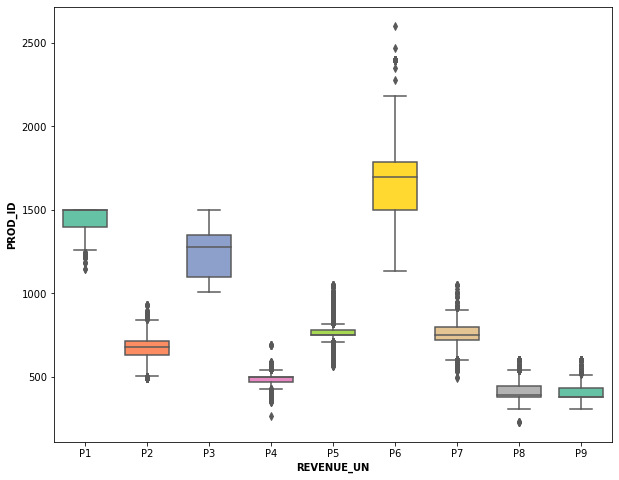

In [14]:
x='PROD_ID' 
y='REVENUE_UN'
order=['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9']
plot_boxplot(df, x, y, order)

# Preparação dos dados

## NORMALIZAR DO DADOS

In [15]:
def normalize_col(df, col_name):
    
    norm = df[[col_name]].values.astype(float)
    min_max_scaler = preprocessing.MinMaxScaler()
    
    x_scaled = min_max_scaler.fit_transform(norm)
    new_col_name = col_name + '_NORMALIZED'
    
    df_normalized = pd.DataFrame(x_scaled)
    df[[new_col_name]] = df_normalized


In [16]:
# col_name = 'REVENUE_UN'
# normalize_col(df, col_name)

In [17]:
df.head()

,PROD_ID,DATE_ORDER,QTY_ORDER,REVENUE,REVENUE_UN
0,P6,2015-08-02,1.0,1808.99,1808.99
1,P6,2015-08-17,1.0,1674.00,1674.00
2,P6,2015-08-17,1.0,1673.95,1673.95
3,P6,2015-08-11,1.0,1674.00,1674.00
4,P6,2015-08-17,1.0,1674.00,1674.00


## Tranformando Col  data type

### Adicionando colunas mês e dia (MONTH / DAY)


In [18]:
df['DATE_ORDER'] =  pd.to_datetime(df['DATE_ORDER'], format='%Y-%m-%d')

df['MONTH'] = df['DATE_ORDER'].dt.month
df['DAY'] = df['DATE_ORDER'].dt.weekday

In [19]:
df.dtypes

PROD_ID               object
DATE_ORDER    datetime64[ns]
QTY_ORDER            float64
REVENUE              float64
REVENUE_UN           float64
MONTH                  int64
DAY                    int64
dtype: object

In [20]:
df.head()

,PROD_ID,DATE_ORDER,QTY_ORDER,REVENUE,REVENUE_UN,MONTH,DAY
0,P6,2015-08-02,1.0,1808.99,1808.99,8,6
1,P6,2015-08-17,1.0,1674.00,1674.00,8,0
2,P6,2015-08-17,1.0,1673.95,1673.95,8,0
3,P6,2015-08-11,1.0,1674.00,1674.00,8,1
4,P6,2015-08-17,1.0,1674.00,1674.00,8,0


### Mapeamento dos valores das datas

In [21]:
# Months = {1:'Jan',2:'Feb',3:'Mar', 4:'Apr', 5:'Mai', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Out'}
# Weekday = {0:"Seg", 1:"Ter", 2:"Qua", 3:"Qui", 4:"Sex", 5:"Sab", 6:"Dom"}

# df['MONTH'].replace(Months, inplace=True) 
# df['DAY'].replace(Weekday, inplace=True)


# Análise dos dados

O objetivo aqui é responder:


1. Qual o produto mais vendido?

2. Qual o preço médio deles?

3. Qual a quantidade de itens pedidos?

4. Qual dias da semana tem maior volume de vendas?

5. Qual mês tem maior volume de vendas?



## Qual o produto mais vendido?

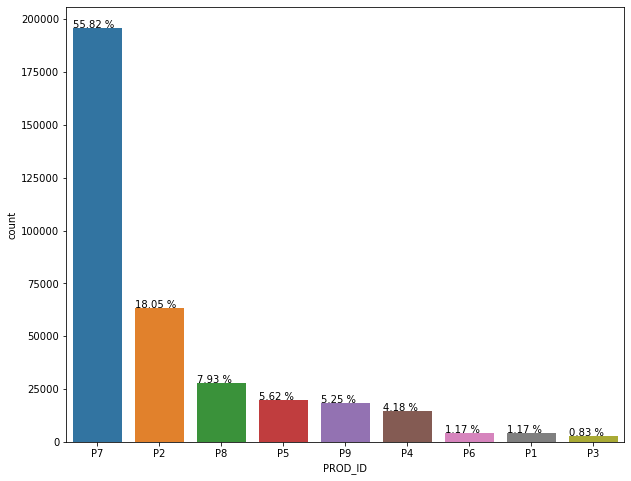

In [22]:
ax = (sns.countplot(x = 'PROD_ID',
              data = df,
              order = df['PROD_ID'].value_counts(normalize=True).index[::1]))


for p in ax.patches:
    estimator = p.get_height() / len(df) * 100.0
    height = p.get_height()
    ax.text(p.get_x(), height+ 3, '{:0.2f} %'.format(estimator))

## Qual o preço médio deles?

In [23]:
def avg_prod_ID(df, col_id, col_price):
    global prod_avg
    column_ID = df[col_id].unique()
    column_ID.sort()
    for i in (column_ID):
        avg = df.loc[df[col_id] == i][col_price].mean()
        prod_avg[i] = round(avg, 2)
    return prod_avg
# df_sales.loc[df_sales['PROD_ID'] == 'P7']['REVENUE_UN'].mean()

prod_avg = {}
avg_prod_ID(df, 'PROD_ID', 'REVENUE_UN')

{'P1': 1442.11,
 'P2': 681.47,
 'P3': 1260.64,
 'P4': 489.88,
 'P5': 756.06,
 'P6': 1673.87,
 'P7': 762.87,
 'P8': 408.66,
 'P9': 406.75}

-  P6 tem o maior PM, porém tem apenas 1% do volume de vendas

-  P9 tem o menor PM e tem 5% do volume de vendas

-  P7 que te o maior volume de vendas, tem PM de $762.87

## Qual a quantidade de itens pedidos?

In [24]:
column_ID = df['QTY_ORDER'].unique()
column_ID.sort()
len(column_ID)

qty_count = {}
for i in (column_ID):
    count = df.loc[df['QTY_ORDER'] == i]['QTY_ORDER'].count()
#     print(count)
    perc = round(count, 4)/len(df)*100
    qty_count[i] = {('Total: ' + str(round(count, 2))) + ' ------ ' + str(round(perc, 2)) + ' %'}
#     qty_count[i] = round(count, 2)
qty_count

{1.0: {'Total: 334968 ------ 95.42 %'},
 2.0: {'Total: 12293 ------ 3.5 %'},
 3.0: {'Total: 1475 ------ 0.42 %'},
 4.0: {'Total: 497 ------ 0.14 %'},
 5.0: {'Total: 1295 ------ 0.37 %'},
 6.0: {'Total: 314 ------ 0.09 %'},
 7.0: {'Total: 8 ------ 0.0 %'},
 8.0: {'Total: 4 ------ 0.0 %'},
 9.0: {'Total: 3 ------ 0.0 %'},
 10.0: {'Total: 84 ------ 0.02 %'},
 11.0: {'Total: 3 ------ 0.0 %'},
 12.0: {'Total: 8 ------ 0.0 %'},
 13.0: {'Total: 1 ------ 0.0 %'},
 14.0: {'Total: 1 ------ 0.0 %'},
 15.0: {'Total: 9 ------ 0.0 %'},
 16.0: {'Total: 3 ------ 0.0 %'},
 17.0: {'Total: 1 ------ 0.0 %'},
 18.0: {'Total: 1 ------ 0.0 %'},
 20.0: {'Total: 13 ------ 0.0 %'},
 23.0: {'Total: 1 ------ 0.0 %'},
 24.0: {'Total: 2 ------ 0.0 %'},
 25.0: {'Total: 3 ------ 0.0 %'},
 27.0: {'Total: 1 ------ 0.0 %'},
 28.0: {'Total: 2 ------ 0.0 %'},
 29.0: {'Total: 1 ------ 0.0 %'},
 30.0: {'Total: 7 ------ 0.0 %'},
 31.0: {'Total: 1 ------ 0.0 %'},
 35.0: {'Total: 2 ------ 0.0 %'},
 37.0: {'Total: 1 ------ 0.0 

-  95.42% das vendas foi apenas com um item.
-  3.5% das vendas foram com dois itens.

- Tiveram duas vendas com 100 itens na compra.  E a maior venda foi com 500 itens.

## Qual dias da semana tem maior volume de vendas

### Mapeamento dos valores das datas


In [25]:
Months = {1:'Jan',2:'Feb',3:'Mar', 4:'Apr', 5:'Mai', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Out'}
Weekday = {0:"Seg", 1:"Ter", 2:"Qua", 3:"Qui", 4:"Sex", 5:"Sab", 6:"Dom"}

df['MONTH'].replace(Months, inplace=True) 
df['DAY'].replace(Weekday, inplace=True)

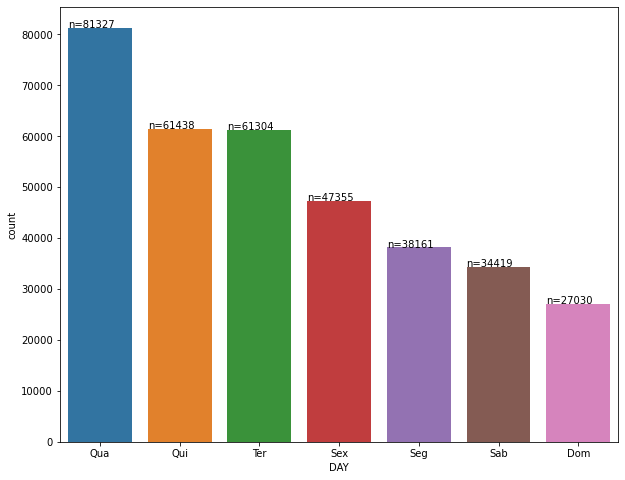

In [26]:
ax = (sns.countplot(x = 'DAY',
              data = df,
              order = df['DAY'].value_counts().index[::1]))

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x(), height+ 3, 'n=%.0f'%(height))

### Podemos verificar se esse padrão de dias se repete para cada produto também.

Volume de vendas dias da semana para o:  P1


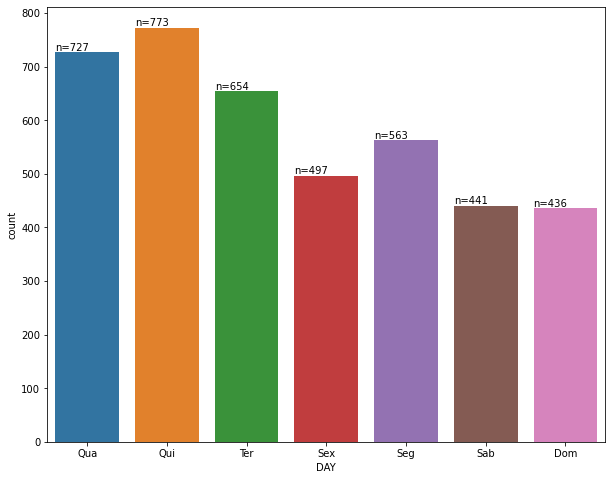

Volume de vendas dias da semana para o:  P2


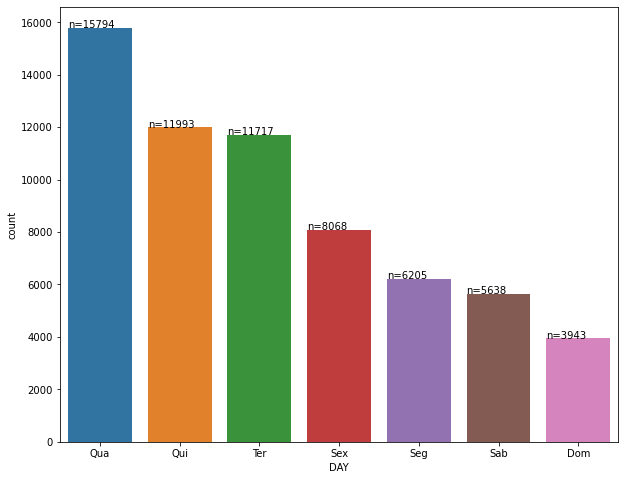

Volume de vendas dias da semana para o:  P3


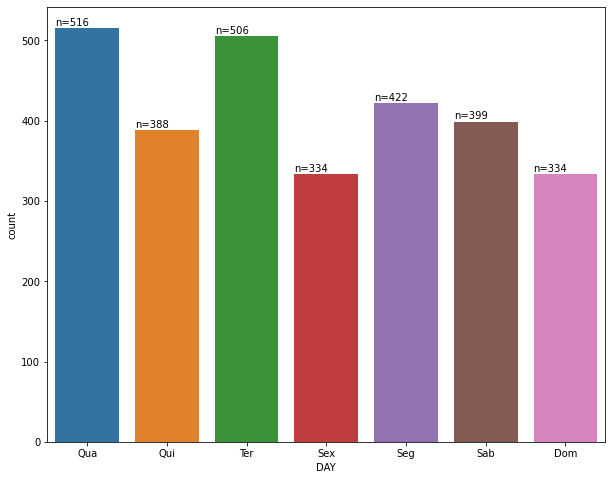

Volume de vendas dias da semana para o:  P4


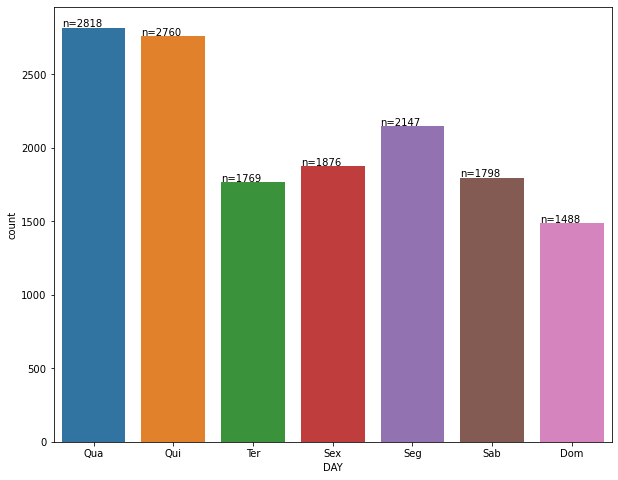

Volume de vendas dias da semana para o:  P5


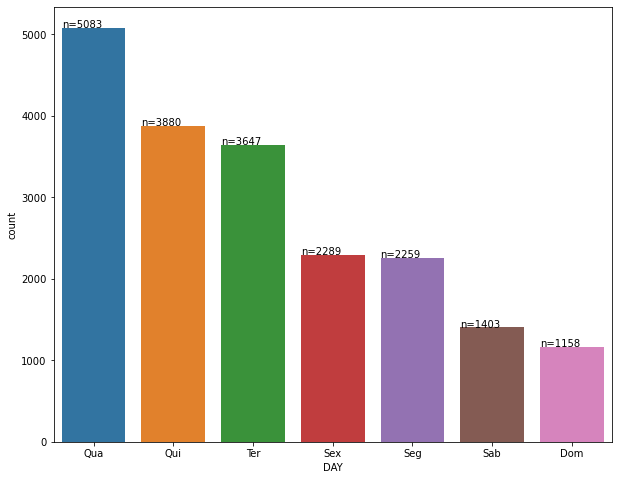

Volume de vendas dias da semana para o:  P6


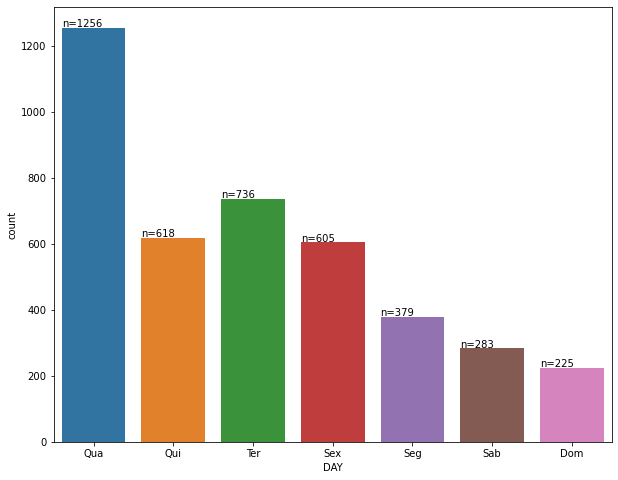

Volume de vendas dias da semana para o:  P7


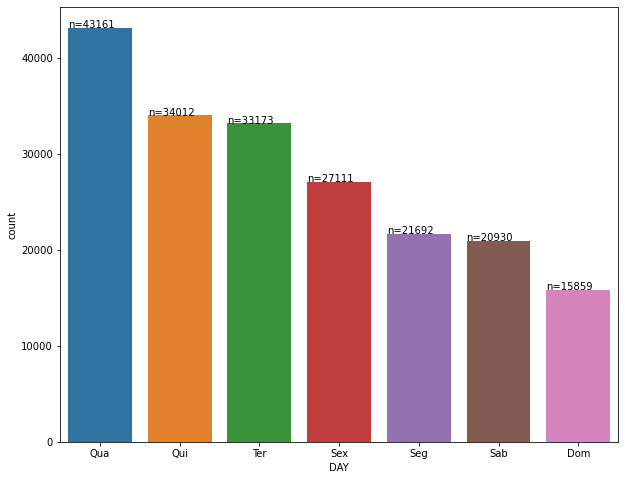

Volume de vendas dias da semana para o:  P8


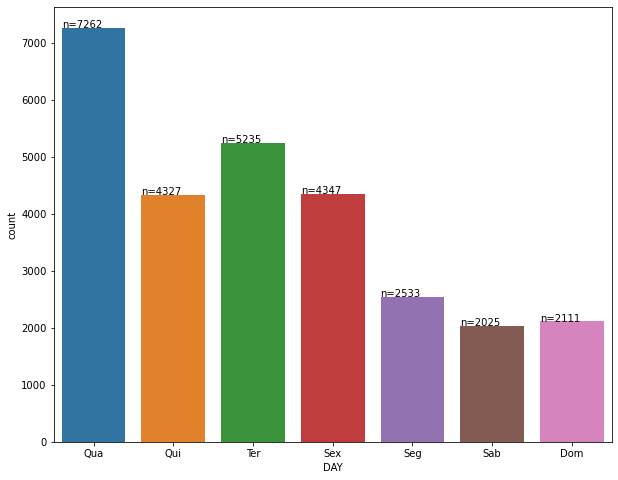

Volume de vendas dias da semana para o:  P9


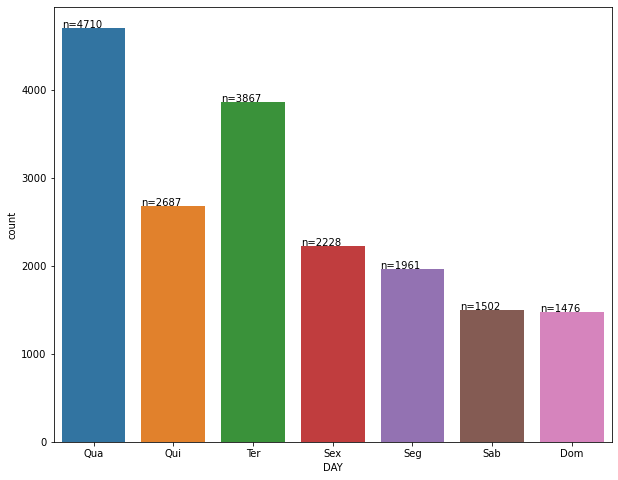

In [27]:
column_ID = df['PROD_ID'].unique()
column_ID.sort()
len(column_ID)

for i in (column_ID):
    print('Volume de vendas dias da semana para o: ', i)
    ax = (sns.countplot(x = 'DAY',
                  data = df.loc[df['PROD_ID'] == i],
                  order = df['DAY'].value_counts().index[::1]))

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x(), height+ 3, 'n=%.0f'%(height))
    plt.show()


- Quarta feira é o dia da semana que mais tem pedidos e domingo o menor.

## Qual mês tem maior volume de vendas?

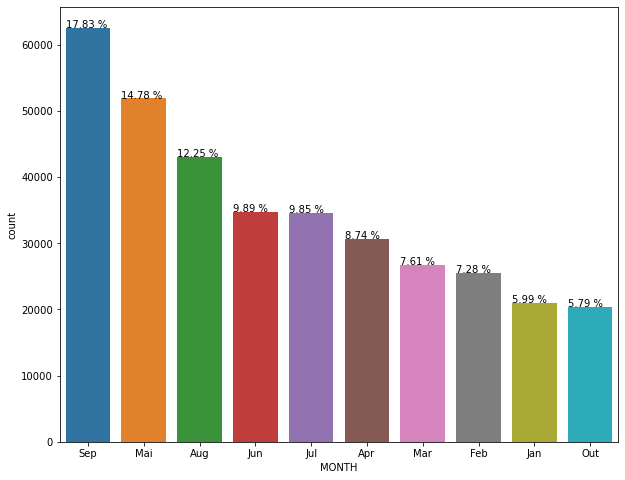

In [28]:
ax = (sns.countplot(x = 'MONTH',
              data = df,
              order = df['MONTH'].value_counts(normalize=True).index[::1]))


for p in ax.patches:
    estimator = p.get_height() / len(df) * 100.0
    height = p.get_height()
    ax.text(p.get_x(), height+ 3, '{:0.2f} %'.format(estimator))

- O mês de outubro não pode ser considerado como o menor de vendas, pois a nossa base de dados possui apenas até o dia 14 de outubro.